# Lab 3

## Author: Konstantin Yakovlev

### Description:

Reimplement experiment from the article "Early stopping as nonparametric variational inference". Compare the results with the results from article.

* [article](https://arxiv.org/pdf/1504.01344.pdf)


### Notes

* Implementation of MLP and data preparation was taken from the
[official tutorial](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html).



## Theory

First, write down ELBO in the following way:

$$\log p(x) \geq S(q(\theta)) + \mathbb{E}_{q(\theta)} \log p(x, \theta).$$


Parameters $\theta$ are updated according to the rule:

$$\theta_{t + 1} = T(\theta_t) = \theta_t - \alpha \nabla_\theta L(\theta, x),$$

where $L(\theta, x) = -\log p(x, \theta)$. We also have an unbiased estimator for the
change in intropy at each iteration:

$$S(q_{t+1}) - S(q_t) = \log \det(I - \alpha H(\theta_t)),$$

where $H(\theta_t)$ is hessian of $L(\theta, x)$ w.r.t. model parameters $\theta$. Note that there is a linear
time esimate of $\log \det(I - \alpha H(\theta_t))$. See Algorithm 2 from the paper.


We are aimed to show that marginal likelihood estimation can be used to determine the number of iterations before
overfitting happens.


## Experimental setup

1. The model is an ordinary MLP with one hidden layer.

2. We perform a classification task on a subsample of MNIST dataset.

3. We use improper prior on model parameters $\theta$, i.e. $p(\theta) \propto 1$.




In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

key = random.PRNGKey(0)

from dataclasses import dataclass
from typing import Tuple

from tqdm import tqdm
from matplotlib import pyplot as plt

import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

In [2]:
@dataclass
class Config:
    step_size: float = 1e-3  # learning rate
    num_epochs: int = 200
    batch_size: int = 32
    layer_sizes: Tuple[int] = (784, 300, 10)  # layer sizes
    train_size: int = 5 * 32  # train data size
    test_size: int = 20 * 32  # test data size
    
cfg = Config()

### Data preparation

In [3]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))
    

In [4]:
mnist_dataset = MNIST('./data', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader([mnist_dataset[i] for i in range(cfg.train_size)],
                                 batch_size=cfg.batch_size, num_workers=2)

In [5]:
# Get full test dataset
mnist_dataset_test = MNIST('./data', download=True, train=False, transform=FlattenAndCast())
testing_generator = NumpyLoader([mnist_dataset_test[i] for i in range(cfg.train_size,
                                                                      cfg.train_size + cfg.test_size)],
                                batch_size=cfg.batch_size, num_workers=0, shuffle=False)

### Model preparation

In [6]:
def random_layer_params(m, n, key, scale=1e-2):
    """Creates MLP layer weight and bias"""
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key):
    """Creates a sequence of parameters for each layer"""
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(cfg.layer_sizes, random.PRNGKey(0))

In [7]:
@jit
def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    """Forward pass"""
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

In [8]:
### TEST
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
print(random_flattened_image.shape)
preds = predict(params, random_flattened_image)
print(preds.shape)

(784,)
(10,)


In [9]:
batched_predict = vmap(predict, in_axes=(None, 0))

random_flattened_images = random.normal(random.PRNGKey(1), (3, 28 * 28))
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(3, 10)


In [10]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jit
def loss(params, images, targets):
    """Cross-entropy loss"""
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
    """Gradient step"""
    grads = grad(loss)(params, x, y)
    return [(w - cfg.step_size * dw, b - cfg.step_size * db) for (w, b), (dw, db) in zip(params, grads)]

### Training loop

In [11]:
params = init_network_params(cfg.layer_sizes, random.PRNGKey(0))

In [12]:
train_losses = []
test_losses = []

global_step = 1
for epoch in tqdm(range(cfg.num_epochs)):
    total_loss = jnp.array(0.0)
    for x, y in testing_generator:
        y = one_hot(y, 10)
        total_loss += loss(params, x, y)
    test_losses.append((global_step, total_loss.item() / len(testing_generator)))
    
    for x, y in training_generator:
        y = one_hot(y, 10)
        train_losses.append((global_step, loss(params, x, y).item()))
        params = update(params, x, y)
        global_step += 1
    
total_loss = jnp.array(0.0)
for x, y in testing_generator:
    y = one_hot(y, 10)
    total_loss += loss(params, x, y)
test_losses.append((global_step, total_loss.item() / len(testing_generator)))

100%|█████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.14it/s]


### Estimate of log-determinant of Jabobian

In [14]:
@jit
def dot_product(p1, p2):
    res = jnp.array(0.0)
    for (w1, b1), (w2, b2) in zip(p1, p2):
        res += (w1 * w2).sum()
        res += (b1 * b2).sum()
    return res

def hvp(params, images, targets, vector):
    """Hessian (w.r.t. parameters) - vector product"""
    return grad(lambda theta : dot_product(vector, grad(loss, 0)(theta, images, targets)))(params)
    

In [15]:
def log_det_jac(params, images, targets):
    """log det jacobian estimation"""
    r_0 = init_network_params(cfg.layer_sizes, random.PRNGKey(0))
    r_0_hvp = hvp(params, images, targets, r_0)
    r_1 = [(w - cfg.step_size * g_w, b - cfg.step_size * g_b) for (w, b), (g_w, g_b) in zip(r_0, r_0_hvp)]
    r_1_hvp = hvp(params, images, targets, r_1)
    r_2 = [(w - cfg.step_size * g_w, b - cfg.step_size * g_b) for (w, b), (g_w, g_b) in zip(r_1, r_1_hvp)]
    res = jnp.array(0.0)
    for (w_0, b_0), (w_1, b_1), (w_2, b_2) in zip(r_0, r_1, r_2):
        res += (w_0 * (-2 * w_0 + 3 * w_1 - w_2)).sum()
        res += (b_0 * (-2 * b_0 + 3 * b_1 - b_2)).sum()
    return res


### Training loop

In [16]:
params = init_network_params(cfg.layer_sizes, random.PRNGKey(0))

In [17]:
marg_likely = []

H = jnp.array(0.0)

for epoch in tqdm(range(cfg.num_epochs)):
    for x, y in training_generator:
        y = one_hot(y, 10)
        H += log_det_jac(params, x, y)
        marg_likely.append(-loss(params, x, y).item() + H.item())
        params = update(params, x, y)

100%|█████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.30it/s]


### Visualization

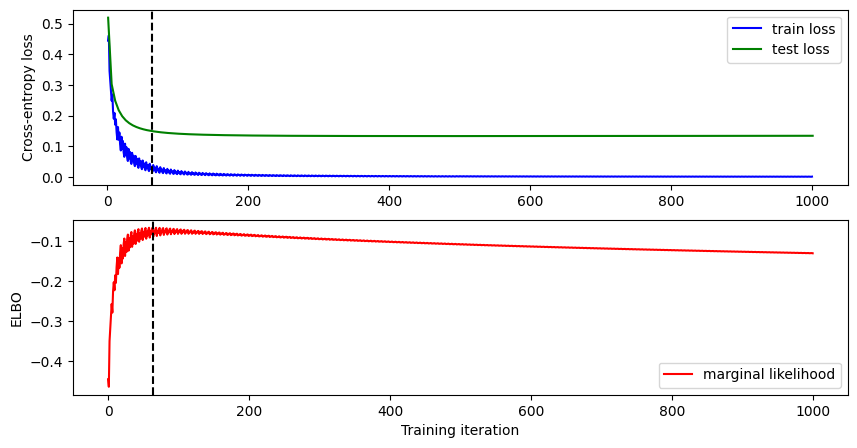

In [19]:
_, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].plot([el[0] for el in train_losses], [el[1] for el in train_losses], label='train loss', color='b')
axs[0].plot([el[0] for el in test_losses], [el[1] for el in test_losses], label='test loss', color='g')
axs[0].set_ylabel('Cross-entropy loss')
axs[0].legend()

axs[1].plot(marg_likely, label='marginal likelihood', color='r')
axs[1].set_ylabel('ELBO')
axs[1].legend()
axs[1].set_xlabel('Training iteration')

argmax = np.argmax(marg_likely)
axs[1].axvline(x=argmax, color='black', ls='--')
axs[0].axvline(x=argmax, color='black', ls='--')

plt.show()

### Conclusion


As we can see, we have managed to reproduce the results from the paper (see Figure 3). The iteration with
maximal ELBO corresponds to the start of overfitting.

